# **Import Module**

In [46]:
# @title
!pip install PySastrawi

In [3]:
# @title
import pandas as pd
import numpy as np
import plotly.express as px
import tensorflow as tf
import nltk
import warnings
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as txt
from transformers import BertTokenizer, TFBertModel
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, classification_report

warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **Load Dataset**

In [4]:
# Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/gnafhan/csv/main/review.csv')
kamus_alay = pd.read_csv('https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/new_kamusalay.csv', encoding='latin')

In [5]:
df.head()

Category                                       Product Name  \
0  Computers and Laptops  Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...   
1  Computers and Laptops  PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...   
2  Computers and Laptops                SSD Midasforce 128 Gb - Tanpa Caddy   
3  Computers and Laptops  ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...   
4  Computers and Laptops  ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...   

                 Location   Price  Overall Rating  Number Sold  Total Review  \
0           Jakarta Utara   53500             4.9         5449          2369   
1  Kota Tangerang Selatan   72000             4.9         2359          1044   
2           Jakarta Barat  213000             5.0        12300          3573   
3           Jakarta Timur   55000             4.7         2030           672   
4           Jakarta Timur   55000             4.7         2030           672   

   Customer Rating                                    Customer Review  \
0                5  Alhamdulillah berfungsi dengan baik. Packaging...   
1                5  barang bagus dan respon cepat, harga bersaing ...   
2                5  barang bagus, berfungsi dengan baik, seler ram...   
3                5  bagus sesuai harapan penjual nya juga ramah. t...   
4                5  Barang Bagus, pengemasan Aman, dapat Berfungsi...   

  Sentiment Emotion  
0  Positive   Happy  
1  Positive   Happy  
2  Positive   Happy  
3  Positive   Happy  
4  Positive   Happy

# **Data Preprocessing**


Cleaning Data

In [6]:
# Checking data
print(f"Data have {sum(df.isna().sum())} null data")
print(f"Data have {df.duplicated().sum()} duplicated data")

Data have 0 null data
Data have 7 duplicated data


In [7]:
# Removing Duplicated data
df.drop_duplicates(subset=['Customer Review'], inplace=True, keep="first")

In [8]:
# Checking data
print(f"Data have {sum(df.isna().sum())} null data")
print(f"Data have {df.duplicated().sum()} duplicated data")

Data have 0 null data
Data have 0 duplicated data


Normalization Text

In [9]:
# make lower str
df['Customer Review']= df['Customer Review'].str.lower()

In [10]:
# Remove special character
df['Customer Review']= df['Customer Review'].str.replace('[^\w\s]', '')

In [11]:
# Change slang words
kamus_alay.rename(columns={'anakjakartaasikasik':'slang', 'anak jakarta asyik asyik':'baku'}, inplace=True)

In [12]:
def replace_slang(review):
    words = review.split()
    for i in range(len(words)):
        slang_word = words[i]
        replacement = kamus_alay[kamus_alay['slang'] == slang_word]['baku'].values
        if len(replacement) > 0:
            words[i] = replacement[0]
    return ' '.join(words)

df['Customer Review']= df['Customer Review'].apply(replace_slang)

In [13]:
# Remove stopword
stop_words = list(stopwords.words('indonesian'))
df['Customer Review'] = df['Customer Review'].apply(lambda x: ' '.join(word for word in word_tokenize(x) if word not in stop_words))
df['Customer Review'] = df['Customer Review'].str.replace(r'\bnya\b', '', regex=True)
df

Category  \
0     Computers and Laptops   
1     Computers and Laptops   
2     Computers and Laptops   
3     Computers and Laptops   
4     Computers and Laptops   
...                     ...   
5395              Household   
5396              Household   
5397              Household   
5398              Household   
5399              Household   

                                           Product Name  \
0     Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...   
1     PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...   
2                   SSD Midasforce 128 Gb - Tanpa Caddy   
3     ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...   
4     ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...   
...                                                 ...   
5395  PCK-01 Penjepit Barang / Pickup Tool Ver.1 Ala...   
5396  Ultrasonic Aroma Diffuser Humidifier Colorful ...   
5397  Ultrasonic Aroma Diffuser Humidifier Colorful ...   
5398  Ultrasonic Aroma Diffuser Humidifier Colorful ...   
5399  TDS Meter 3 Alat Ukur Hidroponik Air Aquarium ...   

                    Location   Price  Overall Rating  Number Sold  \
0              Jakarta Utara   53500             4.9         5449   
1     Kota Tangerang Selatan   72000             4.9         2359   
2              Jakarta Barat  213000             5.0        12300   
3              Jakarta Timur   55000             4.7         2030   
4              Jakarta Timur   55000             4.7         2030   
...                      ...     ...             ...          ...   
5395           Jakarta Pusat   35000             4.9         1431   
5396           Jakarta Utara   99000             4.9        15529   
5397           Jakarta Utara   99000             4.9        15529   
5398           Jakarta Utara   99000             4.9        15529   
5399           Jakarta Utara   14400             4.9         4765   

      Total Review  Customer Rating  \
0             2369                5   
1             1044                5   
2             3573                5   
3              672                5   
4              672                5   
...            ...              ...   
5395           562                5   
5396          4074                5   
5397          4074                5   
5398          4074                5   
5399          3044                5   

                                        Customer Review Sentiment Emotion  
0     alhamdulillah berfungsi packaging aman respon ...  Positive   Happy  
1              barang bagus respon cepat harga bersaing  Positive   Happy  
2     barang bagus berfungsi seler ramah pengiriman ...  Positive   Happy  
3     bagus sesuai harapan penjual  ramah terima kas...  Positive   Happy  
4                barang bagus pengemasan aman berfungsi  Positive   Happy  
...                                                 ...       ...     ...  
5395  harga bersaing barang sesuai pesanan menambah ...  Positive    Love  
5396  beli anak istri liburan jakarta cari cari kete...  Positive    Love  
5397  pengemasan barang kondisi barang utuh cacat be...  Positive   Happy  
5398             mungil murahh terjangkau pas kebutuhan  Positive   Happy  
5399  produk sesuai deskripsi packing aman terlindun...  Positive    Love  

[5305 rows x 11 columns]

In [14]:
# Stemming word
factory = StemmerFactory()
stemmer = factory.create_stemmer()
df['Customer Review'] = df['Customer Review'].apply(stemmer.stem)

In [15]:
df.to_csv('cleaned.csv')

# Data Exploration

General Exploration

In [16]:
df.head()

Category                                       Product Name  \
0  Computers and Laptops  Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...   
1  Computers and Laptops  PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...   
2  Computers and Laptops                SSD Midasforce 128 Gb - Tanpa Caddy   
3  Computers and Laptops  ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...   
4  Computers and Laptops  ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...   

                 Location   Price  Overall Rating  Number Sold  Total Review  \
0           Jakarta Utara   53500             4.9         5449          2369   
1  Kota Tangerang Selatan   72000             4.9         2359          1044   
2           Jakarta Barat  213000             5.0        12300          3573   
3           Jakarta Timur   55000             4.7         2030           672   
4           Jakarta Timur   55000             4.7         2030           672   

   Customer Rating                                    Customer Review  \
0                5  alhamdulillah fungsi packaging aman respon cep...   
1                5              barang bagus respon cepat harga saing   
2                5        barang bagus fungsi seler ramah kirim cepat   
3                5   bagus sesuai harap jual ramah terima kasih lapak   
4                5                      barang bagus emas aman fungsi   

  Sentiment Emotion  
0  Positive   Happy  
1  Positive   Happy  
2  Positive   Happy  
3  Positive   Happy  
4  Positive   Happy

In [17]:
df.describe()

Price  Overall Rating     Number Sold  Total Review  \
count  5.305000e+03     5305.000000     5305.000000   5305.000000   
mean   2.415278e+05        4.854288    15309.179453   2158.940245   
std    8.083569e+05        0.108556    69778.910137   2912.542848   
min    1.000000e+02        4.100000        9.000000      4.000000   
25%    2.000000e+04        4.800000     1565.000000    574.000000   
50%    6.000000e+04        4.900000     3772.000000   1188.000000   
75%    1.500000e+05        4.900000     9695.000000   2561.000000   
max    1.539900e+07        5.000000  1000000.000000  24500.000000   

       Customer Rating  
count      5305.000000  
mean          3.101791  
std           1.762642  
min           1.000000  
25%           1.000000  
50%           3.000000  
75%           5.000000  
max           5.000000



*   Highest price is 15.399M
*   Highest Number Sold is 1M



In [18]:
px.histogram(df, x="Category", y="Price", histfunc='sum', color="Category").show()
print()
print()
px.histogram(df, x="Category", y="Number Sold", histfunc='sum', color="Category").show()




*   Highest price category phones and tablets
*   Highest number sold category other



In [19]:
px.scatter_matrix(df, dimensions=['Number Sold', 'Price', 'Overall Rating', 'Total Review', 'Customer Rating'], color="Sentiment")

***Emotion exploration***

In [20]:
# Showing size each emotion
px.bar(df.groupby('Emotion').size(), color=(df.groupby('Emotion').size()))

Based on data, the highest number of emotion is happy with a total of 1753 customer.

The second highest number of emotion is Sadness with a total of 1185 customer

Most Frequent Words

In [21]:
# Grouping customer review by emotion
df.groupby('Emotion').count()
Happy = df[df['Emotion']== "Happy"]['Customer Review']
Anger = df[df['Emotion']== "Anger"]['Customer Review']
Fear = df[df['Emotion']== "Fear"]['Customer Review']
Love = df[df['Emotion']== "Love"]['Customer Review']
Sadness = df[df['Emotion']== "Sadness"]['Customer Review']
Emotion = [Happy, Anger, Fear, Love, Sadness]
Emotion_Label = ["Happy", "Anger", "Fear", "Love", "Sadness"]

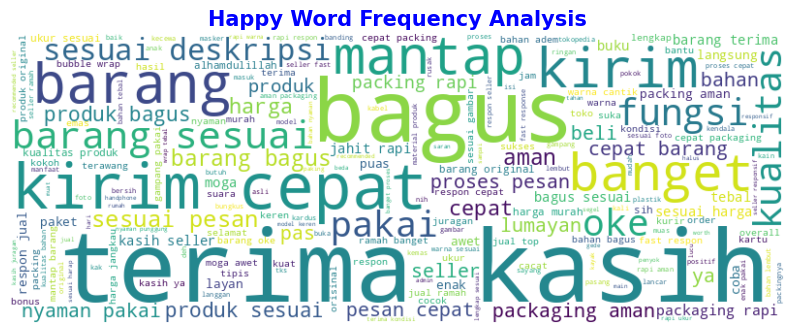

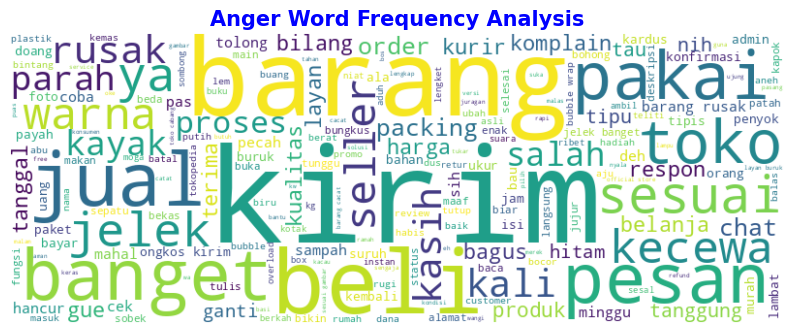

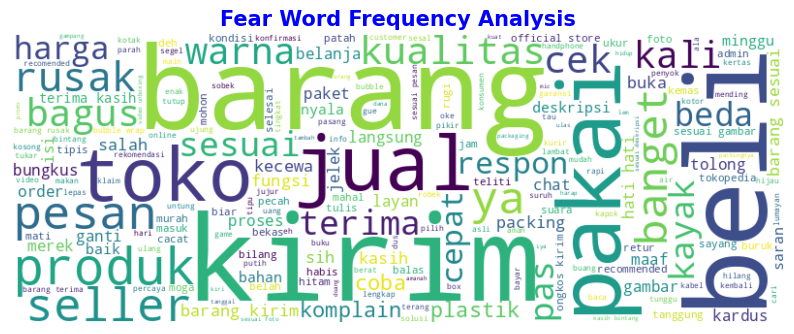

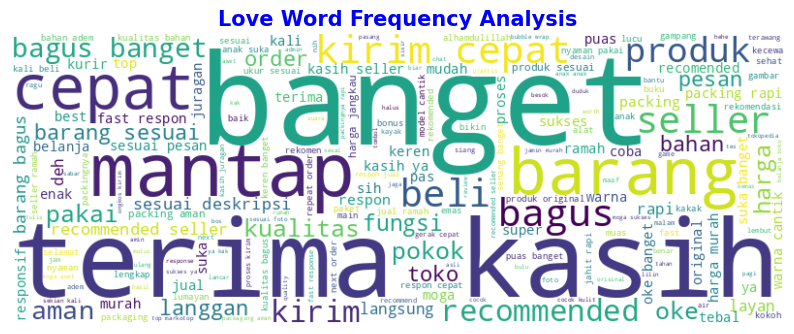

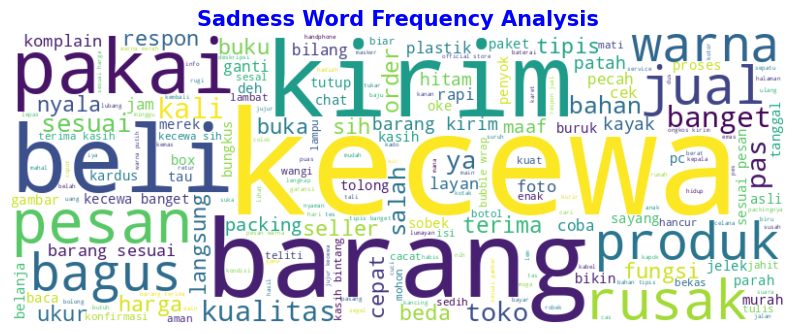

In [22]:
# Visualize the most frequently occurring words
for i in range(len(Emotion)):
  reviews = ' '.join(Emotion[i])
  wordcloud = WordCloud(width=800, height=300, background_color='white').generate(reviews)
  plt.figure(figsize=(10, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'{Emotion_Label[i]} Word Frequency Analysis', fontsize = 15, fontweight = 'bold', color = 'blue')
  plt.savefig(f'{Emotion_Label[i]} Word Frequency Analysis.png')
  plt.show()
  print()
  print()

The result is not good enough, there is still many general words. (barang, jual, beli, produk, kirim, produk, banget, pakai, sesuai, pesan)

In [23]:
# Remove the general words
general_words = ['barang','jual','beli','produk','kirim','produk','banget', 'pakai', 'sesuai', 'pesan']
def delete_general(text):
    for word in general_words:
        if word in text.lower():
            return ""
    return text

new_Emotion = []
for i in Emotion:
  new_Emotion.append(i.apply(delete_general))


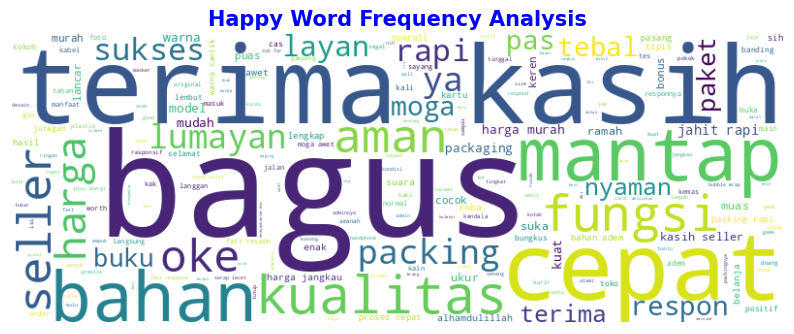

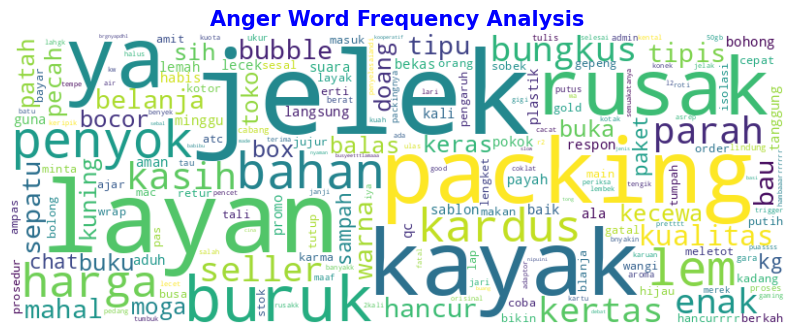

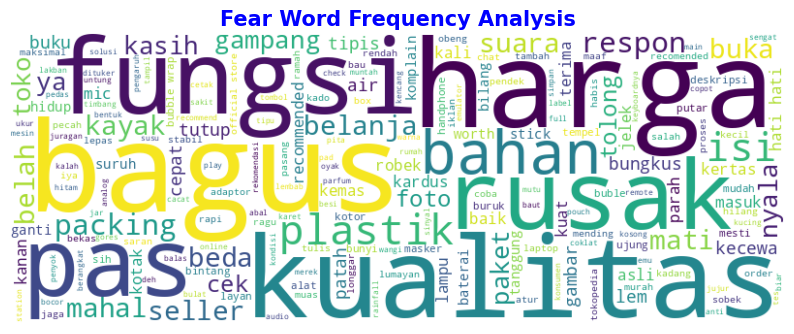

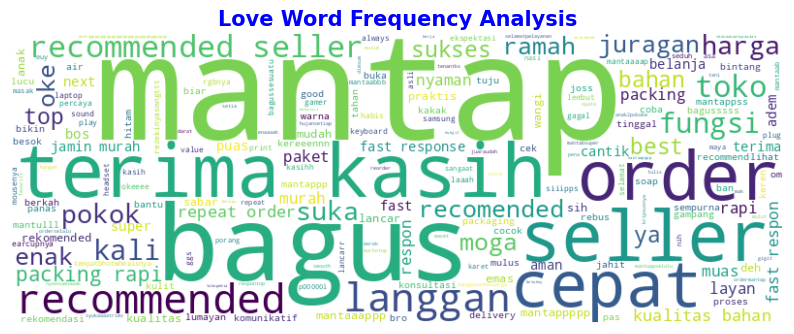

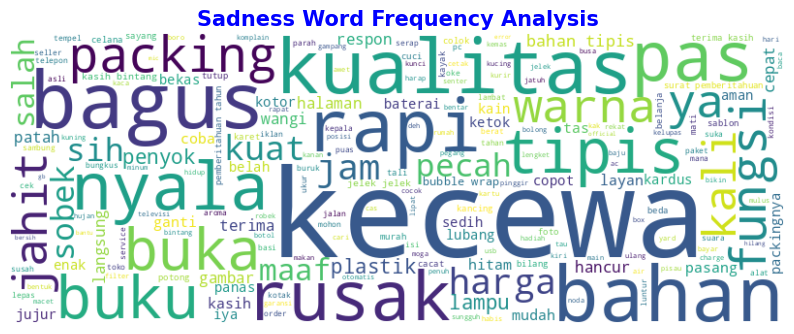

In [24]:
# Visualize the most frequently occurring words
for i in range(len(Emotion)):
  reviews = ' '.join(new_Emotion[i])
  wordcloud = WordCloud(width=800, height=300, background_color='white').generate(reviews)
  plt.figure(figsize=(10, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'{Emotion_Label[i]} Word Frequency Analysis', fontsize = 15, fontweight = 'bold', color = 'blue')
  plt.savefig(f'{Emotion_Label[i]} Word Frequency Analysis.png')
  plt.show()
  print()
  print()

After removing general words, we can see the most frequent words:
1. Happy: Terima kasih, bagus, mantap, cepat, lumayan
2. Anger: Jelek, buruk, penyok, packing, rusak
3. Fear : Harga, bagus, rusak, kualitas, fungsi
4. Love : Mantap, terima kasih, bagus, cepat, recommended
5. Sadness : Kecewa, rusak, tipis

Happy : From the words we know customer very happy with the product or service

Anger: Customer very angry maybe the packaging is broken

Fear : Customer Fear about the quality and compare it with price, one of the reason buy the product is the function

Love: Customer very love the products and service

Sadness: Customer very sad because the quality of products is bad and not good enough

In [25]:
# Frequency each emotion
for i in range(len(Emotion)):
  reviews = ' '.join(new_Emotion[i])
  words = reviews.split()
  word_freq = Counter(words)
  word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
  word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)
  fig = px.bar(word_freq_df.head(10), x='Word', y='Frequency', title=f'{Emotion_Label[i]} The most frequen words', width= 800, height=300, color='Frequency')
  fig.show()
  print()
  print()

Correlative between price and rating

In [26]:
# Grouping customer review by emotion
df.groupby('Emotion').count()
Happy = df[df['Emotion']== "Happy"]
Anger = df[df['Emotion']== "Anger"]
Fear = df[df['Emotion']== "Fear"]
Love = df[df['Emotion']== "Love"]
Sadness = df[df['Emotion']== "Sadness"]
Emotion = [Happy, Anger, Fear, Love, Sadness]
Emotion_Label = ["Happy", "Anger", "Fear", "Love", "Sadness"]

In [27]:
for i in range(len(Emotion)):
  fig = px.box(Emotion[i], x='Customer Rating', y='Price', title=Emotion_Label[i])
  fig.show()
  print()
  print()

From data we can conclude,

Happy : There is no rating 1 and 2, higher price also make higher rating or satisfaction Median 70k

Anger : There is no rating 5, and the median is 44k but have 1 value 15M. Median 44.9k

Fear: There is no rating 5, have one data price 15M and rating 3. Median 44.9k

Love: Almost same like happy, Median 78k

Sadness: All rating have sadness emotion, median 50k

To reach better quality and happy satisfaction, good product is above 70k

***Sentiment exploration***

In [28]:
px.bar(df.groupby('Sentiment').size())

The dataset have 2700 Negative Sentiment and 2553 Negative Sentiment

In [29]:
# Grouping customer review by sentiment
Positive = df[df["Sentiment"]=="Positive"]
Negative = df[df["Sentiment"]=="Negative"]
pos_review = Positive['Customer Review'].apply(delete_general)
neg_review = Negative['Customer Review'].apply(delete_general)
sentiment = [pos_review, neg_review]
sentiment_label = ["Positive", "Negative"]

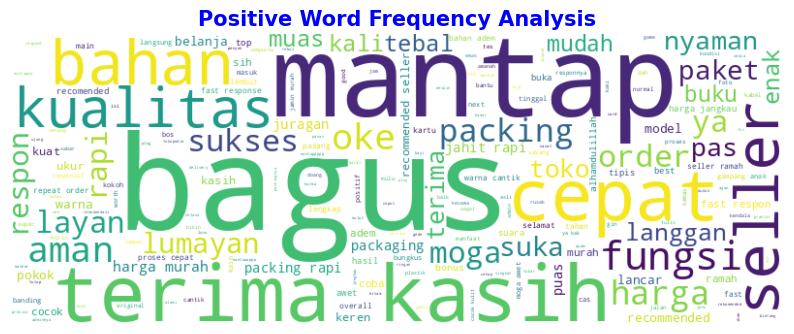

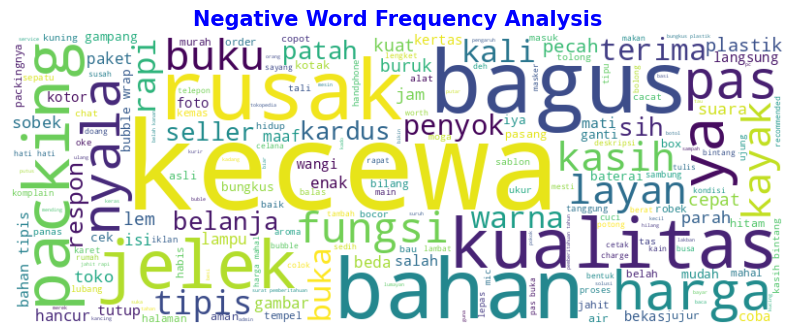

In [30]:
# Make wordcloud using grouped sentiment
for i in range(len(sentiment)):
  reviews = ' '.join(sentiment[i])
  wordcloud = WordCloud(width=800, height=300, background_color='white').generate(reviews)
  plt.figure(figsize=(10, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'{sentiment_label[i]} Word Frequency Analysis', fontsize = 15, fontweight = 'bold', color = 'blue')
  plt.savefig(f'{sentiment_label[i]} Word Frequency Analysis.png')
  plt.show()
  print()
  print()

In [31]:
# Show numbers of the most frequen words
for i in range(len(sentiment)):
  reviews = ' '.join(sentiment[i])
  words = reviews.split()
  word_freq = Counter(words)
  word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
  word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)
  fig = px.bar(word_freq_df.head(10), x='Word', y='Frequency', title=f'{sentiment_label[i]} The most frequen words', width= 800, height=300, color='Frequency')
  fig.show()
  print()
  print()

Positive: customer using bagus and terima kasih for their review

Negative: Customer using kecewa for negative sentiment, and the quality is one of factor

In [32]:
sentiment = [Positive, Negative]
for i in range(len(sentiment)):
  fig = px.box(sentiment[i], x='Customer Rating', y='Price', title=sentiment_label[i])
  fig.show()
  print()
  print()

The good quality of positive sentiment is at median 69k

The bad quality of negative sentiment is at median 45k

# NLP Prediction Sentiment with Conventional Machine Learning

Import dataset

In [33]:
df_nlp = pd.read_csv('https://raw.githubusercontent.com/gnafhan/csv/main/review.csv')

Splitting text and label

In [34]:
X = df_nlp['Customer Review']
y = df_nlp['Sentiment'].apply(lambda x: 1 if x == "Positive" else 0)

Splitting train and test

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

Trying fit some models

In [36]:
models = [
    ('LogisticRegression', LogisticRegression()),
    ('SVC', SVC()),
    ('RandomForest', RandomForestClassifier()),
    ('XGBoost', xgb.XGBClassifier()),
    ('MultinomialNB', MultinomialNB()),
    ('BernoulliNB', BernoulliNB()),
]

for model_name, model in models:
    text_clf = Pipeline([
        ('vectorizer', CountVectorizer(binary=True)),
        ('classifier', model)
    ])
    text_clf.fit(X_train, y_train)
    y_pred = text_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} - Accuration: {accuracy:.4f}")

LogisticRegression - Accuration: 0.9500
SVC - Accuration: 0.9407
RandomForest - Accuration: 0.9167
XGBoost - Accuration: 0.9259
MultinomialNB - Accuration: 0.9324
BernoulliNB - Accuration: 0.8556


Final model using logistic regression

In [37]:
model = Pipeline([
    ('vectorizer', CountVectorizer(binary=True)),
    ('classifier',  LogisticRegression())
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       546
           1       0.96      0.94      0.95       534

    accuracy                           0.95      1080
   macro avg       0.95      0.95      0.95      1080
weighted avg       0.95      0.95      0.95      1080



Visualize with confusion matrix

In [38]:
fig = px.imshow(confusion_matrix(y_test, y_pred),text_auto=True)
fig.update_layout(
    xaxis_title="Prediction",
    yaxis_title="Test"
)

Export Model

In [39]:
pickle.dump(model, open('model.pkl', 'wb'))

# NLP Prediction Emotion with Conventional Machine Learning

Define text and label

In [40]:
X = df_nlp['Customer Review']
y = pd.get_dummies(df_nlp['Emotion']).to_numpy()
y = np.argmax(y, axis=1)

Split train and test

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
y_train

array([2, 2, 0, ..., 3, 2, 4])

Trying fit some models

In [42]:
models = [
    ('LogisticRegression', LogisticRegression()),
    ('SVC', SVC()),
    ('RandomForest', RandomForestClassifier()),
    ('XGBoost', xgb.XGBClassifier()),
    ('MultinomialNB', MultinomialNB()),
    ('BernoulliNB', BernoulliNB()),
]

for model_name, model in models:
    text_clf = Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('classifier', model)
    ])
    text_clf.fit(X_train, y_train)
    y_pred = text_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} - Accurayion: {accuracy:.4f}")

LogisticRegression - Accurayion: 0.6287
SVC - Accurayion: 0.6139
RandomForest - Accurayion: 0.5731
XGBoost - Accurayion: 0.6028
MultinomialNB - Accurayion: 0.5074
BernoulliNB - Accurayion: 0.4676


Select final model

In [43]:
multi_model = Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('classifier', LogisticRegression())
    ])

multi_model.fit(X_train, y_train)
y_pred = multi_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.35      0.43       144
           1       0.47      0.47      0.47       185
           2       0.72      0.87      0.79       339
           3       0.73      0.49      0.59       164
           4       0.59      0.67      0.63       248

    accuracy                           0.63      1080
   macro avg       0.61      0.57      0.58      1080
weighted avg       0.63      0.63      0.62      1080



Visualize with confusion matriks

In [44]:
labels = ["anger", "fear", "happy", "love", "sadness"]
fig = px.imshow(confusion_matrix(y_test, y_pred),
                labels=dict(x="Predicted", y="Actual", color="Count"),
                x=labels,
                y=labels,
                color_continuous_scale="Plotly3", text_auto=True)


fig.update_xaxes(title_text="Predicted")
fig.update_yaxes(title_text="Actual")

fig.update_layout(title_text="Confusion Matrix")

fig.show()



*   Model sudah dapat membedakan happy love dengan sadness fear anger
*   Model masih bingung membedakan antara happy dengan love dan sadness dengan anger



Save model

In [45]:
pickle.dump(multi_model, open('multi_model.pkl', 'wb'))